In [136]:
#Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap

import warnings

warnings.filterwarnings('ignore')

In [137]:
add_new = True          # add session and time of day variables
remove_nans = False     # remove rows containing nans completely

In [138]:
path = Path().cwd()
dataPath = path / "data" / "HR_data_2.csv" #path.parent

data_org = pd.read_csv(dataPath)
set(data_org.dtypes)

data_org.sort_values(['Cohort', 'Round', 'Phase'], inplace=True)
data_org.reset_index(drop=True, inplace=True)


if remove_nans: data_org = data_org.dropna()

types = ['Round','Phase','Cohort','Individual','Puzzler']


if add_new:
    cohort_to_session = {
        'D1_1': 'D11',  # winter
        'D1_2': 'D12',  # Fall
        'D1_3': 'D13',  # fall
        'D1_4': 'D13',  # fall
        'D1_5': 'D13',  # fall
        'D1_6': 'D13',  # fall
    }

    # Create a new column
    data_org['Session'] = data_org['Cohort'].map(cohort_to_session)
    types.append('Session')

    cohort_to_timeCompleted = {
        'D1_1': 'Unknown',  # winter
        'D1_2': 'Unknown',  # Fall
        'D1_3': 'Morning',  # fall
        'D1_4': 'Evening',  # fall
        'D1_5': 'Morning',  # fall
        'D1_6': 'Evening',  # fall
    }

    data_org['TimeCompleted'] = data_org['Cohort'].map(cohort_to_timeCompleted)
    types.append('TimeCompleted')

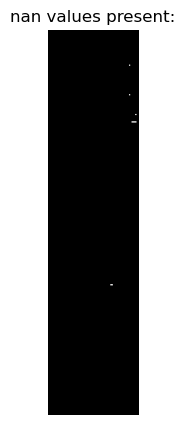

In [139]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(data_org.isna(), cmap='binary_r')
ax.set_title('nan values present:')
ax.axis('off')
plt.show()

In [140]:
result_columns = ['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min',
       'HR_TD_Max', 'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope',
       'TEMP_TD_Mean', 'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min',
       'TEMP_TD_Max', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew',
       'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean',
       'TEMP_TD_Slope', 'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std',
       'EDA_TD_P_Min', 'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis',
       'EDA_TD_P_Skew', 'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max',
       'EDA_TD_P_Slope_mean', 'EDA_TD_P_Slope', 'EDA_TD_T_Mean',
       'EDA_TD_T_Median', 'EDA_TD_T_std', 'EDA_TD_T_Min', 'EDA_TD_T_Max',
       'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis', 'EDA_TD_T_Skew',
       'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max', 'EDA_TD_T_Slope_mean',
       'EDA_TD_T_Slope', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT', 'EDA_TD_P_ReT']
answers_columns = ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired', 'nervous',
       'attentive', 'afraid', 'active', 'determined']

In [141]:
# Import Data
Data_results = copy.copy(data_org[result_columns])
Data_type = copy.copy(data_org[types])
Data_answers = copy.copy(data_org[answers_columns])

# Convert to int
for t in types[:3]:
    # print(set(Data_type[t]))
    Data_type[t] = Data_type[t].str[-1].astype(int)
Data_type

# Fill NaNs
Data_results = Data_results.fillna(Data_results.mean())
Data_answers = Data_answers.fillna(Data_answers.median())


# for d in [Data_results,Data_type,Data_answers]:
#     print(np.sum(d.isnull().any(axis=0)))

# ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired','nervous', 'attentive', 'afraid', 'active', 'determined']

# Flip negative columns (this way, higher number -> positive semantic meaning)
pos_list = ['inspired','attentive','active','determined']
ten_list = ['Frustrated']

new_columns = {}
for col in Data_answers:
    if col in ten_list:
        Data_answers[col] = Data_answers[col].values/2
    if col not in pos_list:
        print(f'{col} is flipped')
        new_columns[col] = col + '_flip'
        Data_answers[col] = 5-Data_answers[col]
Data_answers.rename(columns=new_columns, inplace=True)


Frustrated is flipped
upset is flipped
hostile is flipped
alert is flipped
ashamed is flipped
nervous is flipped
afraid is flipped


In [142]:
#onehot Data_type
Data_type_onehot = pd.get_dummies(Data_type, columns = types,drop_first=True)

data = pd.concat([Data_results, Data_answers, Data_type_onehot], axis=1)

# Standardize the numerical data
scaler = StandardScaler()
Data = scaler.fit_transform(data)

In [143]:
types

['Round',
 'Phase',
 'Cohort',
 'Individual',
 'Puzzler',
 'Session',
 'TimeCompleted']

In [147]:
types.remove('Individual') # not suitable for clustering

### Isomap (shows clustering nicely)

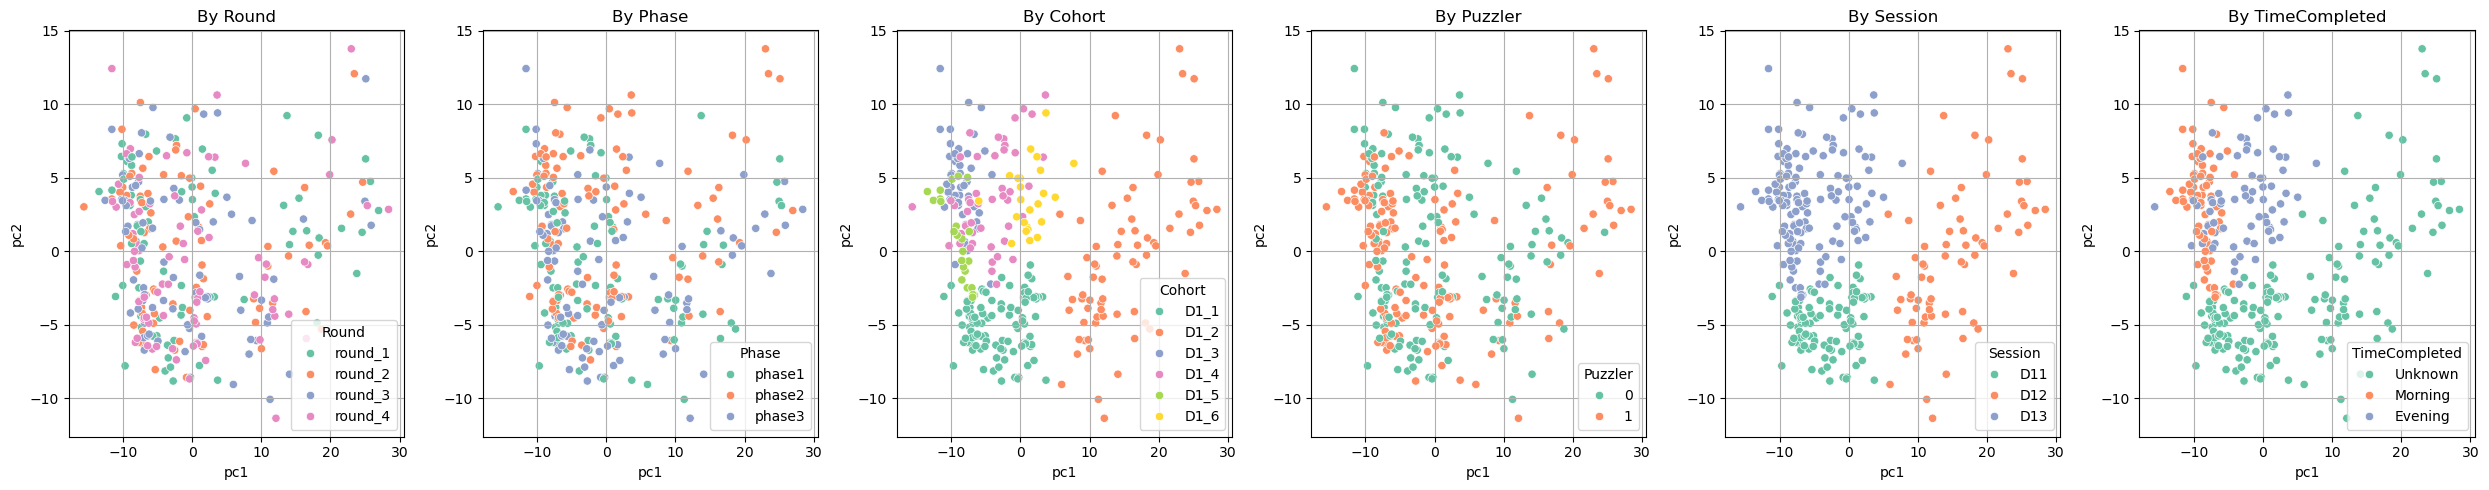

In [201]:
isomap = Isomap(n_neighbors=30, n_components=2)
isomap_components = isomap.fit_transform(Data)

isomap_df = pd.DataFrame(isomap_components, columns=["pc1", "pc2"])

fig, axes = plt.subplots(1, len(types), figsize=(25, 5))
for i,t in enumerate(types):
    isomap_df[t] = data_org[t].values
    
    sns.scatterplot(data=isomap_df, x="pc1", y="pc2", hue=t, ax=axes[i], palette="Set2")
    axes[i].set_title(f"By {t}")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [210]:
# Use plot_by to show clusters split by p colored by t

def plot_by(model,p_name,t):
    plts = data_org[p_name].unique()
    fig, axes = plt.subplots(1, len(plts), figsize=(len(plts)*5, 5),sharey=True,sharex=True)
    for i,p in enumerate(plts):
        filter_data = model[model[p_name] == p]
        sns.scatterplot(data=filter_data, x="pc1", y="pc2", hue=t, ax=axes[i], palette="Set2",legend=(i == 0))
        axes[i].set_title(f"{p} (colored by {t})")
        axes[i].grid(True)
        axes[0].legend(loc='upper left',bbox_to_anchor=(-0.45, 1), title=t)

    plt.tight_layout()
    plt.show()

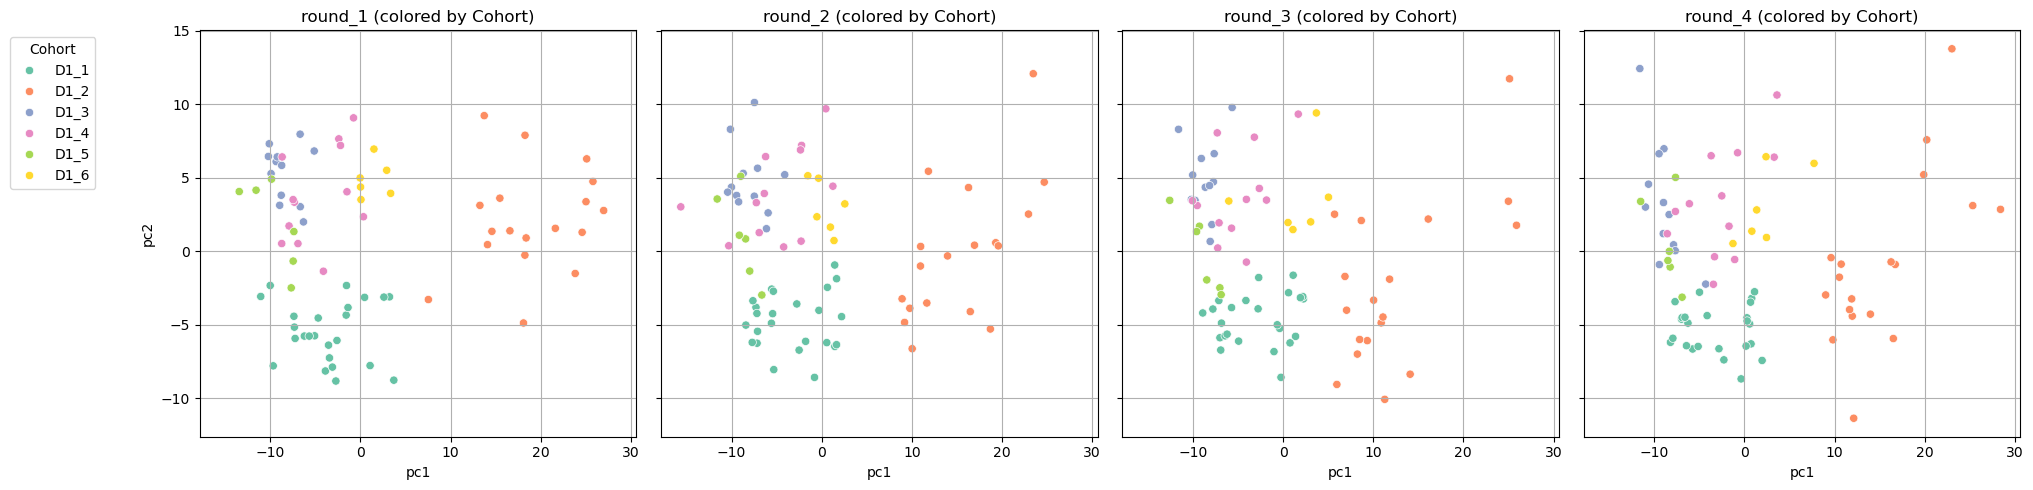

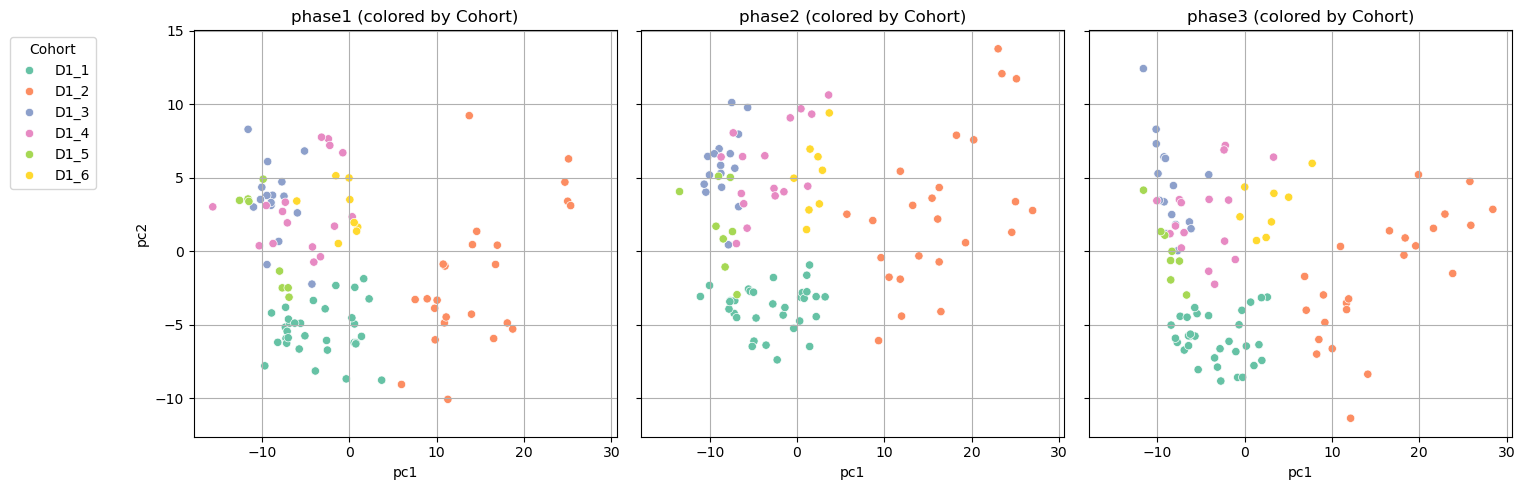

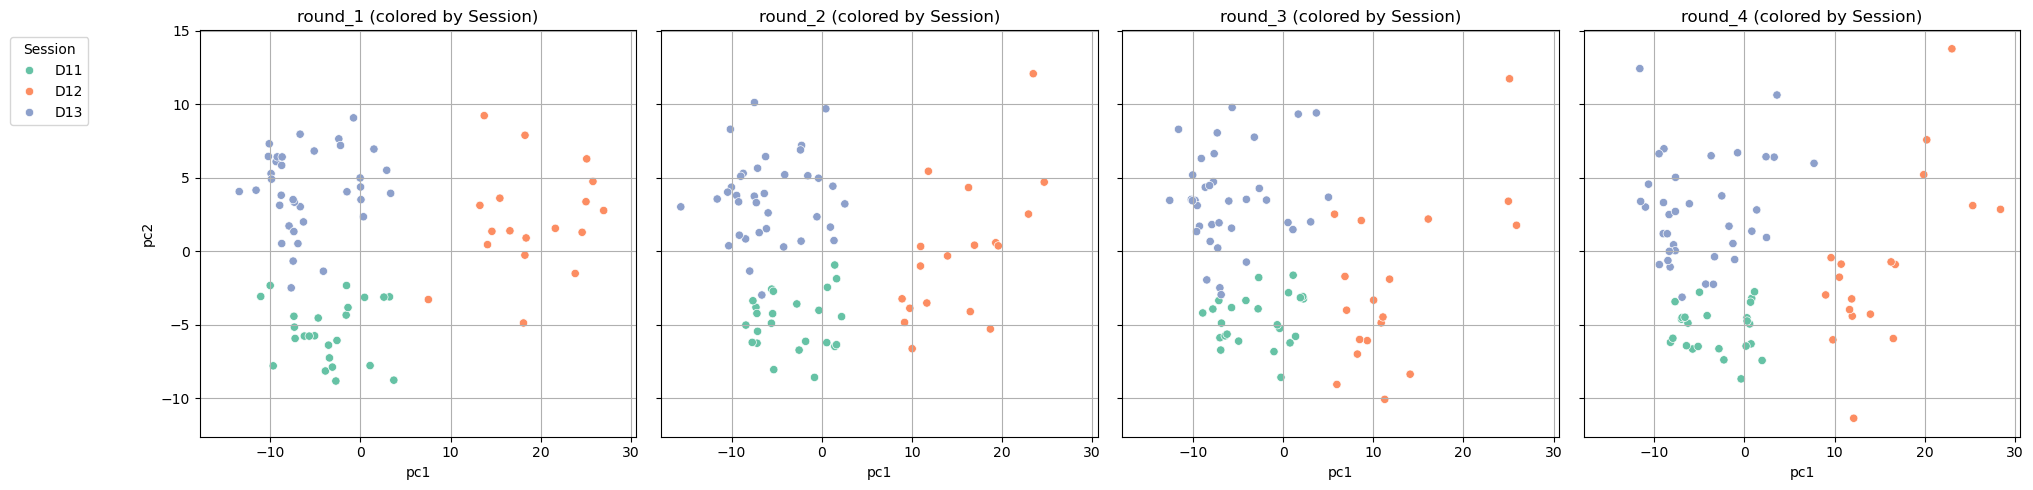

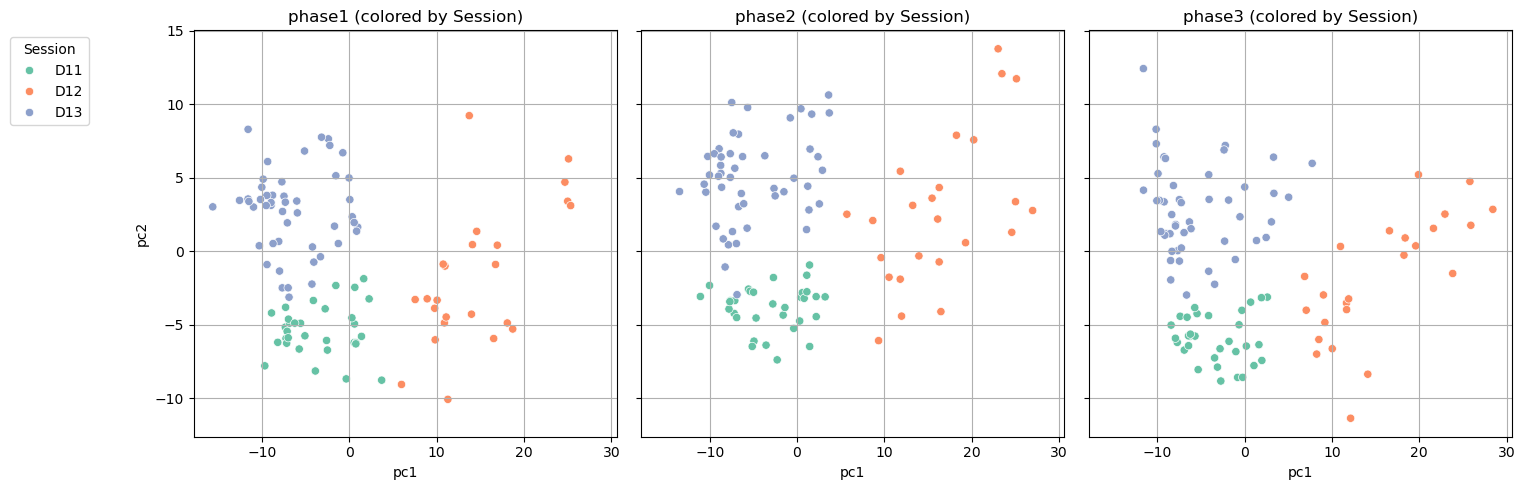

In [213]:
plot_by(isomap_df,'Round','Cohort') # Plot each round and color them by Cohort (D1_1-6)
plot_by(isomap_df,'Phase','Cohort') # Plot each phase and color them by Cohort

plot_by(isomap_df,'Round','Session') # Plot each round and color them by session (D1_1-3)
plot_by(isomap_df,'Phase','Session') # Plot each phase and color them by session

### Kernel PCA (shows very little)

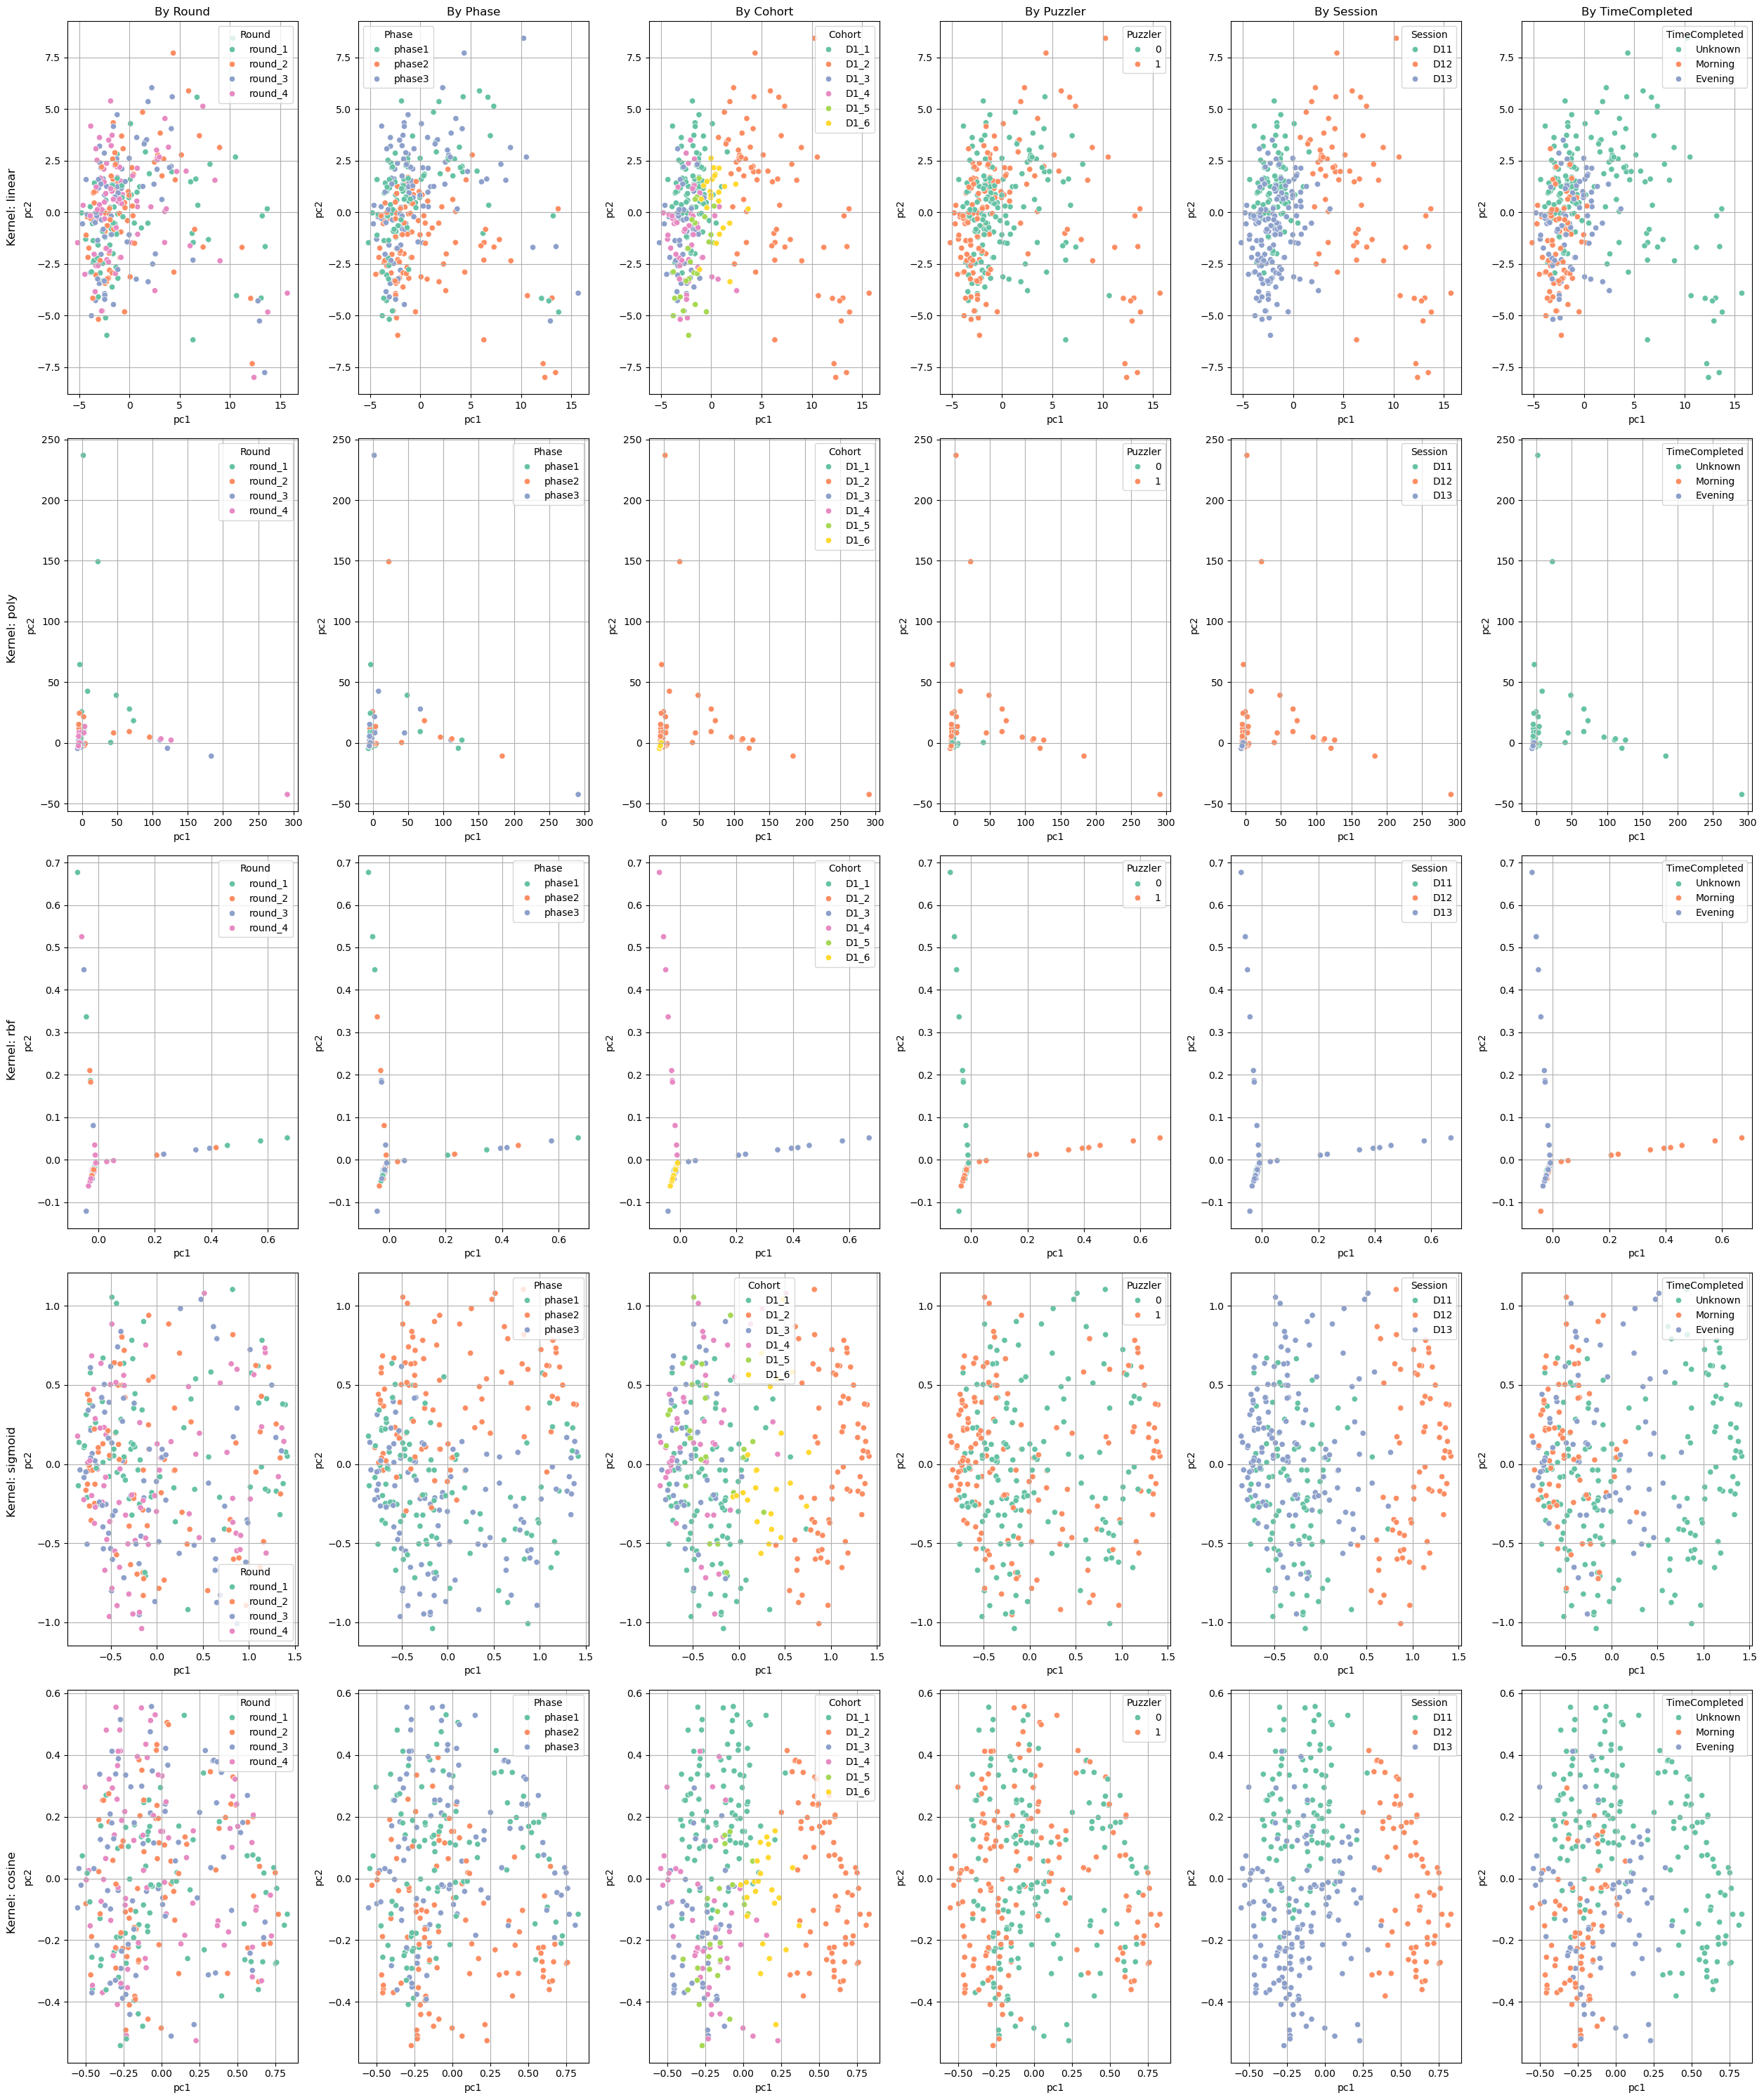

In [208]:
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']

plt_rows = len(kernel_list)
plt_cols = len(types)
fig, axes = plt.subplots(plt_rows, plt_cols, figsize=(plt_rows*5, plt_cols*5)) 
kpca_list = dict()
for j,k in enumerate(kernel_list):

    kpca = KernelPCA(n_components=2, kernel=k, gamma=0.1) # {'linear', 'poly', 'rbf', 'sigmoid', 'cosine', 'precomputed'}
    kpca_components = kpca.fit_transform(Data)

    kpca_df = pd.DataFrame(kpca_components, columns=["pc1", "pc2"])
    kpca_list[k] = kpca_df

    for i,t in enumerate(types):
        kpca_df[t] = data_org[t].values
        
        sns.scatterplot(data=kpca_df, x="pc1", y="pc2", hue=t, ax=axes[j][i], palette="Set2")
        axes[0][i].set_title(f"By {t}")
        axes[j][i].grid(True)
        if i==0:
            fig.text(0, 1-j/plt_rows-0.1, f'Kernel: {k}', va='center', ha='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()

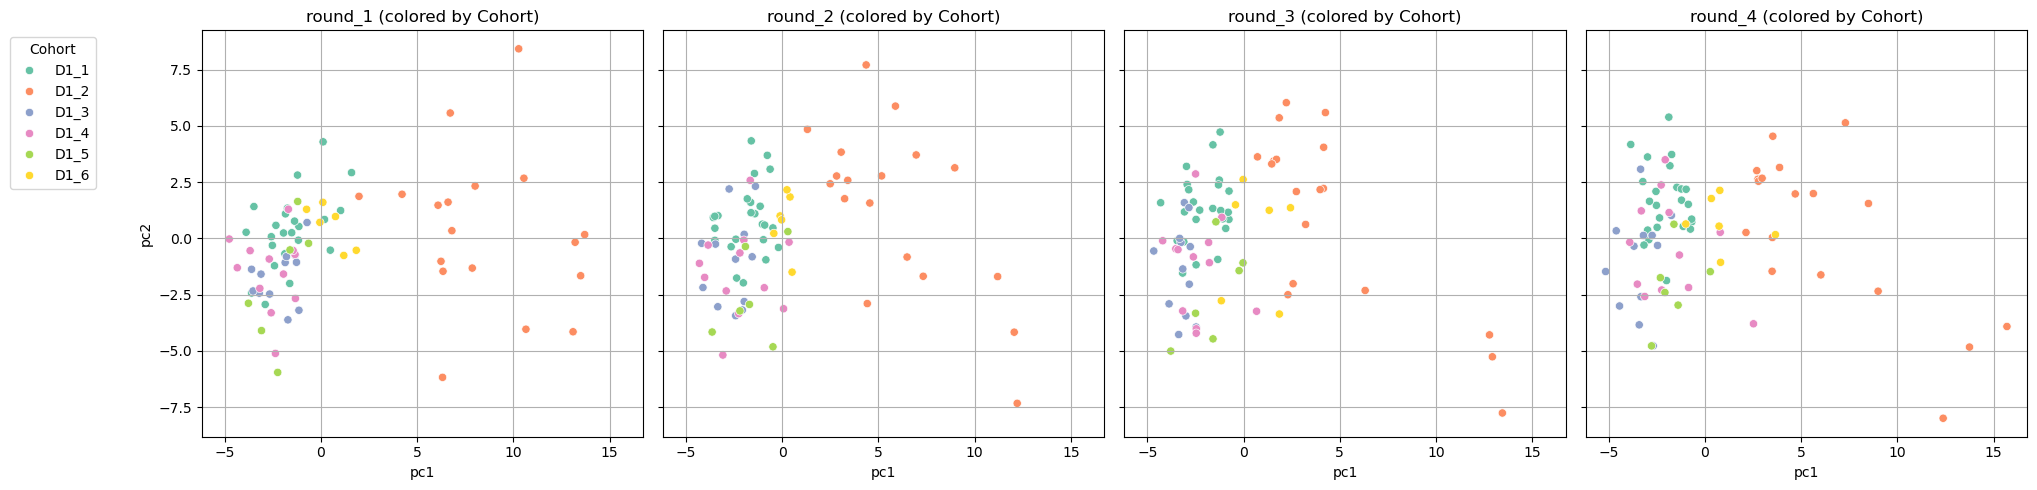

In [209]:
plot_by(kpca_list['linear'],'Round','Cohort')